In [1]:
import numpy as np
import pandas as pd
import re
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.patches as mpatches
from IPython.display import display
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from IPython.display import HTML

import hots_data as hots

# %matplotlib inline

HOTSLogs data found.


In [2]:
players = hots.load_replay_chars(hots.TEAM_LEAGUE).fillna(0)
winners = players[players['Is Winner'] == 1]

In [3]:
def stats():
    cols = ['Takedowns', 'Killing Blows', 'Assists', 'Deaths', 'Hero Damage', 'Siege Damage',
        'Healing', 'Damage Taken', 'Experience Contribution', 'Merc Camp Captures']
    heroes = winners[['HeroID'] + cols].groupby(['HeroID'])
    stats = list()
    idx = []
    for h_id, hero in heroes:
        idx.append(h_id)
        hstat = hero[cols].quantile([.5])
        stats.append(list(hstat.loc[.5].values))
    
    return pd.DataFrame.from_records(
        MinMaxScaler().fit_transform(stats), 
        index=idx, 
        columns=cols)

In [4]:
data = stats()

In [5]:
def dimensions(n):
    return ['Dimension '+str(x) for x in range(1, int(n)+1)]

In [6]:
def pca_results(data, pca):
    d = dimensions(len(pca.components_))
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys())
    components.index = d
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = d
    fig, ax = plt.subplots(figsize = (14,8))
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(d, rotation=0)
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
    plt.show()

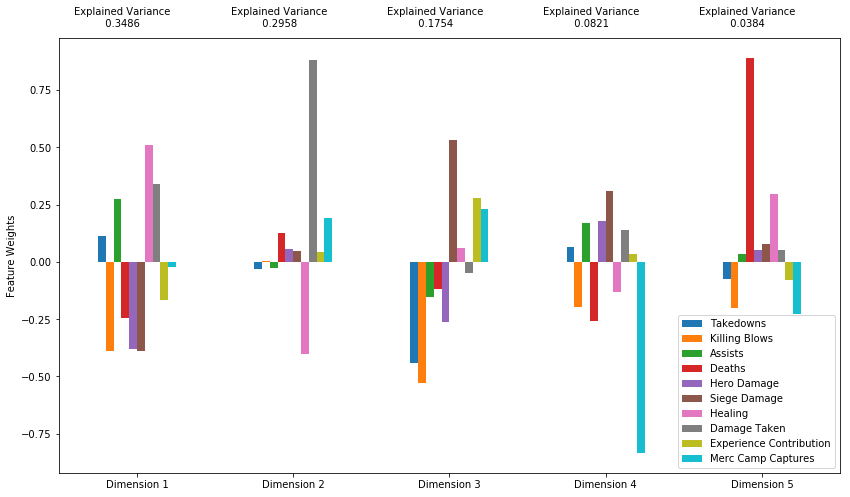

explained variance by 5 PCs 0.9403268038570977


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(data)

pca_data = pd.DataFrame(pca.transform(data), columns = dimensions(pca.n_components), index = data.index)

pca_results(data, pca)
print("explained variance by 5 PCs {}".format(np.sum(pca.explained_variance_ratio_[:5])))

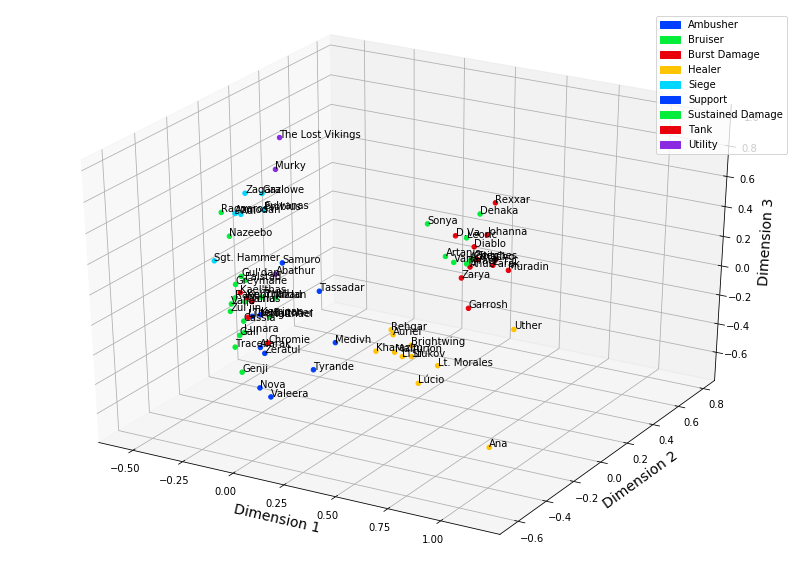

In [8]:
def hero_id_to_subgroup_color(hero_id):
    s = hots.hero_subgroups.index(hots.heroes.loc[hero_id].SubGroup)
    return 'C{}'.format(s if s < 3 else s+1)

def subgroup_colors():
    colors = [hero_id_to_subgroup_color(hero_id) for hero_id in pca_data.index.values]
    handles = [mpatches.Patch(color='C'+str(i if i < 3 else i+1), label=hots.hero_subgroups[i]) for i in range(0, len(hots.hero_subgroups))]
    return (colors, handles)

def biplot(names=True, show_features=False, draw=True):
    fig = plt.figure(figsize = (7,5))
    plt.style.use('seaborn-bright')
    ax = fig.add_subplot(111, projection='3d')

    d = dimensions(3)
    
    colors, handles = subgroup_colors()

    plt.legend(handles=handles)

    ax.scatter(
        pca_data.loc[:, d[0]], pca_data.loc[:, d[1]], pca_data.loc[:, d[2]], 
        c=colors,
        alpha=1
    )

    if names:
        for hero_id in pca_data.index.values:
            ax.text(
                pca_data.loc[hero_id, d[0]], pca_data.loc[hero_id, d[1]], pca_data.loc[hero_id, d[2]],
                hots.heroes.loc[hero_id].Name)

    if show_features:
        feature_vectors = pca.components_.T
        O, U, V, W = [0] * len(feature_vectors), [], [], []
        for i, v in enumerate(feature_vectors):
            U.append(v[0])
            V.append(v[1])
            W.append(v[2])
        ax.quiver(O, O, O, U, V, W, length=1.5)

    ax.set_xlabel(d[0], fontsize=14)
    ax.set_ylabel(d[1], fontsize=14)
    ax.set_zlabel(d[2], fontsize=14)

    ax.dist = 9.5
    ax.autoscale()
    if draw:
        plt.show()

        
    return (fig, ax)
    
#print(plt.style.available)

biplot(names=True);

In [9]:
fig, ax = biplot(names=True, draw=False)

def animate(i):
    ax.view_init(elev=10., azim=i*3)
    return fig,

    
anim = animation.FuncAnimation(fig, animate, frames=120, interval=100, blit=True)
HTML(anim.to_html5_video()) 

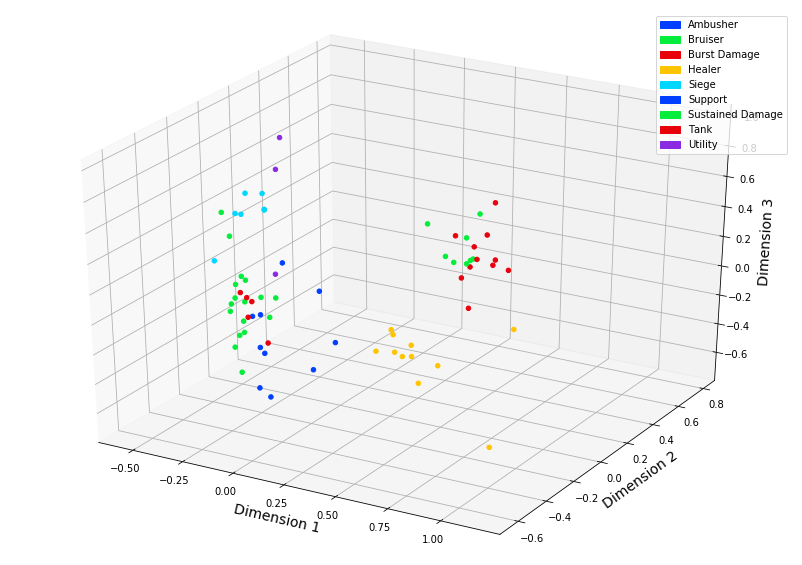

In [11]:
biplot(names=False);